In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt

In [50]:
class AudioDataset(Dataset):
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.file_list = os.listdir(data_folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_folder, self.file_list[idx])
        waveform, sample_rate = torchaudio.load(file_path)
        return waveform, sample_rate

In [76]:
import torch.nn.functional as F

class LatentDiffusionModel(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(LatentDiffusionModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, hidden_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_channels * 2, hidden_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(hidden_channels, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  
        )

    def forward(self, x):
        x, lengths = pad_packed_sequence(x, batch_first=True)
        x = self.encoder(x)
        x = self.decoder(x)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        return x


In [77]:
input_channels = 1  
output_channels = 1  
hidden_channels = 64 

In [78]:
model = LatentDiffusionModel(input_channels, output_channels, hidden_channels)


In [79]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
data_folder = r"C:\Users\dharu\OneDrive\Desktop\NUSProject\classes\airplane"
dataset = AudioDataset(data_folder)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [81]:
num_epochs = 5
for epoch in range(num_epochs):
    for batch in dataloader:
        input_data, sample_rate = batch
        input_data = input_data.unsqueeze(1)  
        lengths = [seq[0].size(0) if len(seq[0].size()) > 0 else 1 for seq in batch]
        padded_sequences = torch.nn.utils.rnn.pad_sequence([seq[0] if len(seq[0].size()) > 0 else seq[0].view(1) for seq in batch], batch_first=True)
        packed_input = pack_padded_sequence(padded_sequences, lengths, batch_first=True, enforce_sorted=False)
        output_packed = model(packed_input)
        output_unpacked, _ = pad_packed_sequence(output_packed, batch_first=True)
        loss = criterion(output_unpacked, padded_sequences)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 972404864.0000
Epoch [1/5], Loss: 972382784.0000
Epoch [2/5], Loss: 972382784.0000
Epoch [2/5], Loss: 972382784.0000
Epoch [3/5], Loss: 972382784.0000
Epoch [3/5], Loss: 972382784.0000
Epoch [4/5], Loss: 972360896.0000
Epoch [4/5], Loss: 972360896.0000
Epoch [5/5], Loss: 972360896.0000
Epoch [5/5], Loss: 972360896.0000


Epoch [1/5], Loss: 972360896.0000


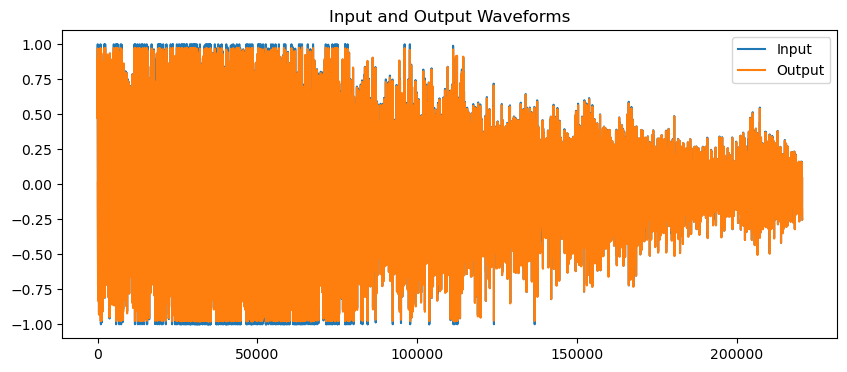

Epoch [1/5], Loss: 972360896.0000


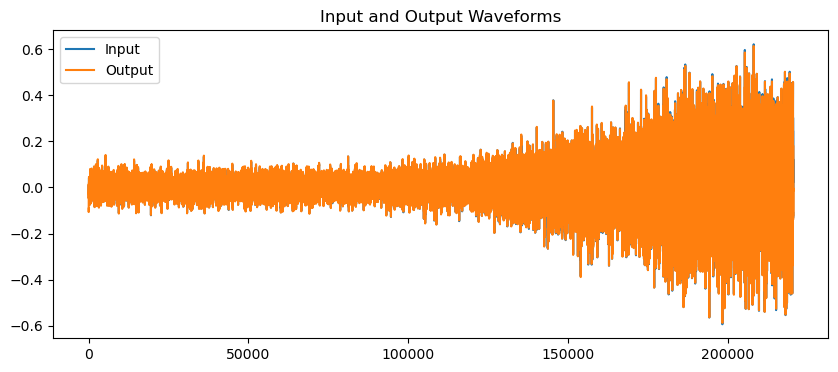

Epoch [2/5], Loss: 972360896.0000


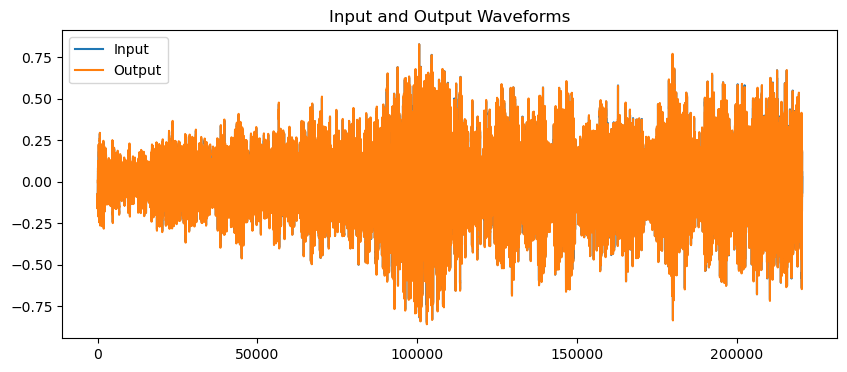

Epoch [2/5], Loss: 972360896.0000


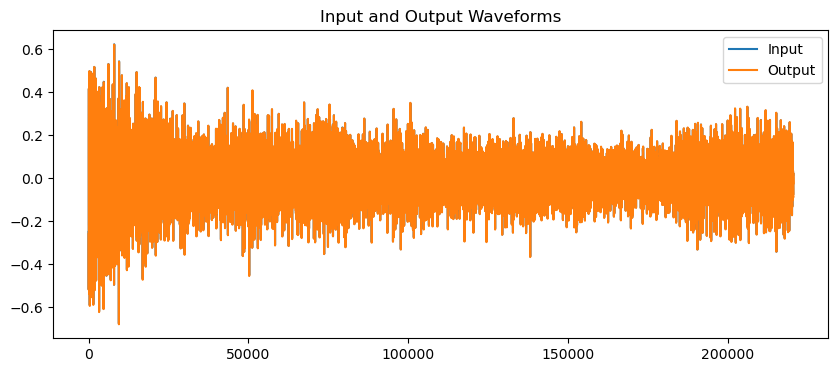

Epoch [3/5], Loss: 972360896.0000


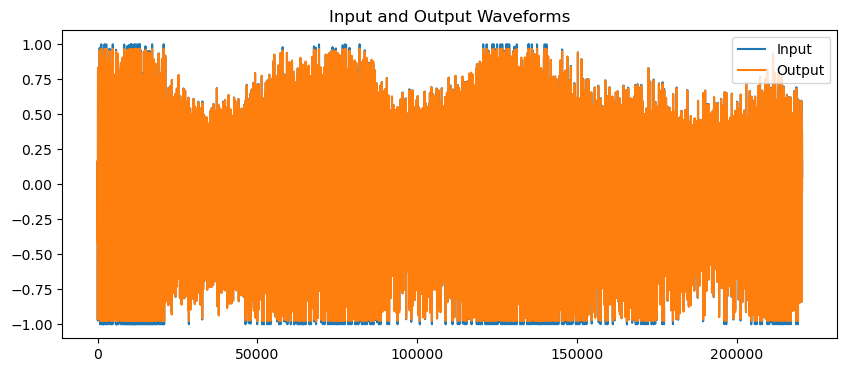

Epoch [3/5], Loss: 972360896.0000


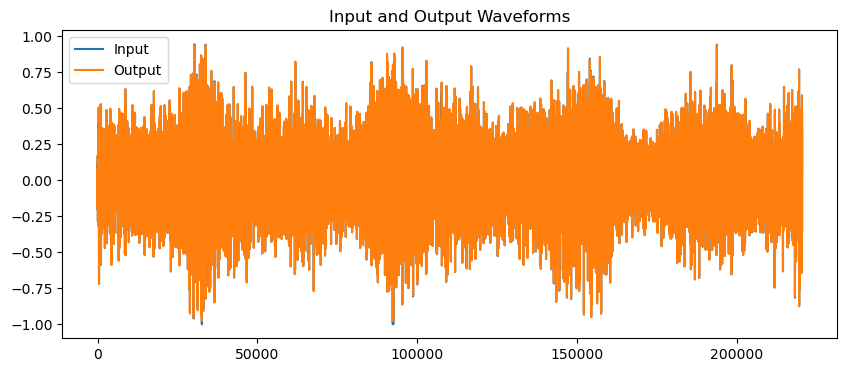

Epoch [4/5], Loss: 972360896.0000


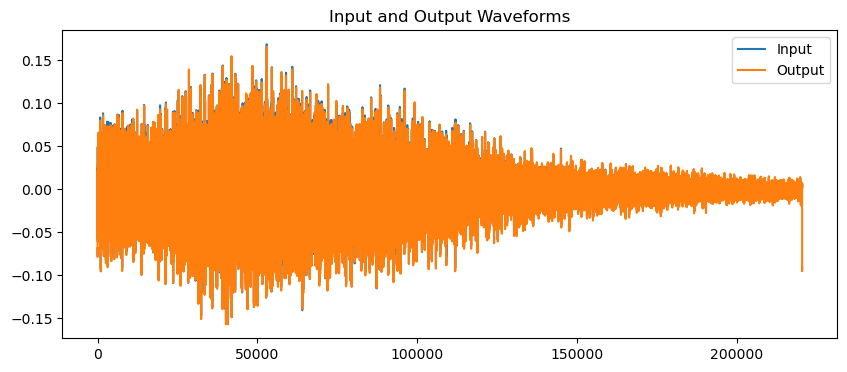

Epoch [4/5], Loss: 972360896.0000


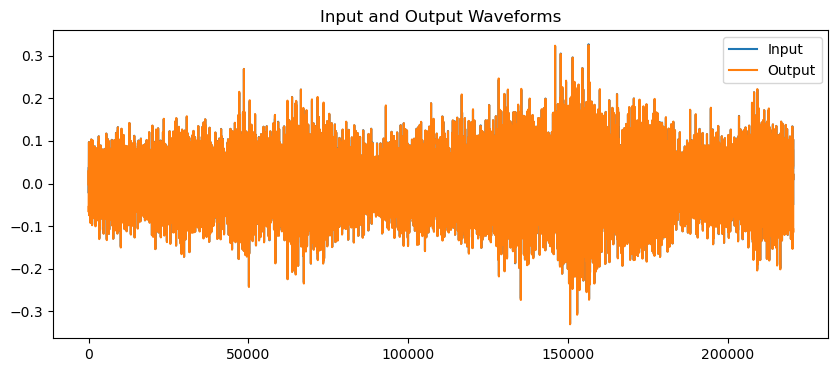

Epoch [5/5], Loss: 972360896.0000


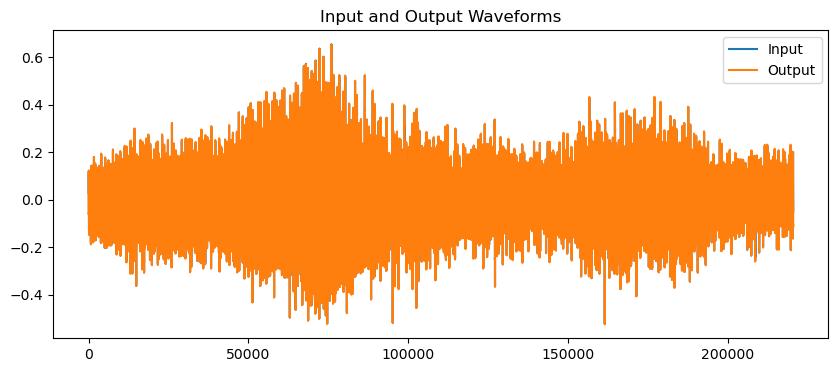

Epoch [5/5], Loss: 972360896.0000


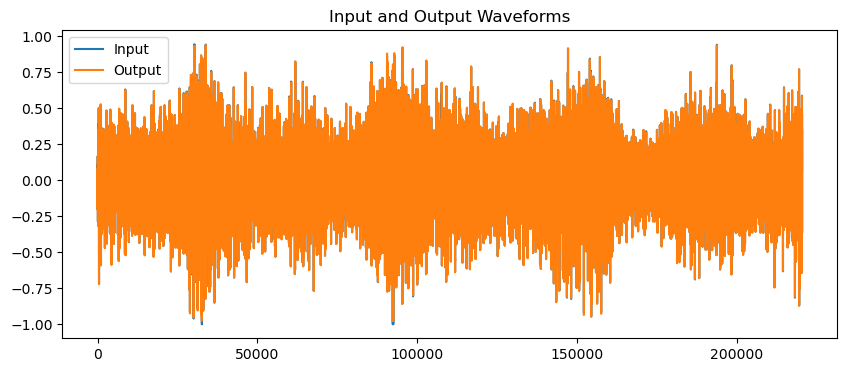

In [57]:
num_epochs = 5
for epoch in range(num_epochs):
    for batch in dataloader:
        input_data, sample_rate = batch
        input_data = input_data.unsqueeze(1)
        lengths = [seq[0].size(0) if len(seq[0].size()) > 0 else 1 for seq in batch]
        padded_sequences = torch.nn.utils.rnn.pad_sequence([seq[0] if len(seq[0].size()) > 0 else seq[0].view(1) for seq in batch], batch_first=True)
        packed_input = pack_padded_sequence(padded_sequences, lengths, batch_first=True, enforce_sorted=False)
        output_packed = model(packed_input)
        output_unpacked, _ = pad_packed_sequence(output_packed, batch_first=True)
        loss = criterion(output_unpacked, padded_sequences)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        input_waveform = input_data[0].squeeze().numpy()
        output_waveform = output_unpacked[0].squeeze().detach().numpy()

        plt.figure(figsize=(10, 4))
        plt.plot(input_waveform, label='Input')
        plt.plot(output_waveform, label='Output')
        plt.title('Input and Output Waveforms')
        plt.legend()
        plt.show()

In [82]:
model.eval()

LatentDiffusionModel(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(64, 1, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (3): Tanh()
  )
)